In [2]:
from math import *
from scipy import special
import numpy as np
import cmath
import time
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Image, SVG, Math, YouTubeVideo
import matplotlib.pyplot as plt
import openpyxl

In [3]:
def sinc(x):
    '''
    Compute the sinc-function: sin(x) / x
    '''
    try:  
        return sin(x) / x
    except ZeroDivisionError:
        return 1.

In [4]:
def upperRecurency(value, Nmax):
    
    # Nmax is the larger index of requirement functions but quantity 
    # of required functions is (Nmax + 1) cause 0-index is included
    
    # Initialization the zero-arrays for calculating the functions
    sphj, sphy, new_sphj = np.zeros(Nmax + 1), np.zeros(Nmax + 1), np.zeros(Nmax + 501)
    
    # Check for non-zero value
    if value:
        
        # Compute the spherical Bessels functions of the first kind of zero 
        # and first-indexes in the current value
        sphj[0] = sinc(value)                                           # n = 0
        sphj[1] = (-1) * cos(value) / value + sin(value) / (value ** 2) # n = 1
        
        # Compute the spherical Bessels functions of the second kind of zero
        # and first-indexes in the current value
        sphy[0] = (-1) * cos(value) / value                             # n = 0
        sphy[1] = (-1) * sin(value) / value - cos(value) / (value ** 2) # n = 1  
        
    
    else:
        # "value == 0" case
        sphj[0] = special.spherical_jn(0, value)
        sphj[1] = special.spherical_jn(1, value)
        
        sphy[0] = special.spherical_yn(0, value)
        sphy[1] = special.spherical_yn(1, value)
        
    # Compute the spherical Bessels functions of the second kind another indexes
    # with bottom-to-top recurrency relation
    for ind in range(2, Nmax + 1):
#         print((2 * ind - 1) / value * sphy[ind - 1] - sphy[ind - 2])
        sphy[ind] = (2 * ind - 1) / value * sphy[ind - 1] - sphy[ind - 2]

    Nz = trunc(value) if value > 1 else 5
    if (Nz >= Nmax):
        for ind in range(2, Nmax + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]
        return (sphj, sphy)
    
    if (Nz < Nmax):
            
        # For another kind of spherical Bessels functions the previous algorithm isn't stable
        # and we calculate only the part of necessary functions
        for ind in range(2, Nz + 1):
            sphj[ind] = (2 * ind - 1) / value * sphj[ind - 1] - sphj[ind - 2]


        # For another part we should use the top-to-bottom recurrency relation

        # Initialization {Nmax + 500} and {Nmax + 499}-indexes for this relation.
        # We should extend our quantity of calculating functions by 500
        # After that our 'new' spherical Bessels functions of the first kind will be known,
        # but it will be the real functions multiplied by the some const.
        new_sphj[Nmax + 500] = 0 # n = Nmax + 500
        new_sphj[Nmax + 499] = 1 # n = Nmax + 499

        # Calculate the 'new' spherical Bessels functions of the first kind of {98 + Nmax} down to {0} - indexes
        for ind in range(498 + Nmax, Nz - 1, -1):
            new_sphj[ind] = (2 * ind + 3) / value * new_sphj[ind + 1] - new_sphj[ind + 2]

            # We shouldn't forget about the fact that our 'new' functions dramatically increases step-by-step.
            # To avoid overflowing, we reduce all of the previous calculating functions by division on max in the array
            if abs(new_sphj[ind]) > 100:
                Max = np.max(new_sphj)

                # We don't care about indexes which we don't want to compute
                if ind <= Nmax:
                    for index in range(ind, Nmax + 1):
                        new_sphj[index] /= Max

                # For this case we should reduce only the {current index + 1} and {current index} functions
                # to continue our calculation
                else:
                    new_sphj[ind + 1] /= Max
                    new_sphj[ind] /= Max
                    
        # After all calculations we want to know the const of relation between the 'new'
        # and known Bessels functions of the first kind
        k = new_sphj[Nz] / sphj[Nz]

        # Initialize the new array for recalculation our 'new' Bessels functions with known constant
        bessels = []
        
        for elem in sphj:
            if elem != 0:
                bessels.append(elem)

        # Division all the 'new' functions by known constant
        for ind in range(Nz + 1, len(new_sphj[:Nmax + 1])):
#             if new_sphj[ind] != 0:
            bessels.append(new_sphj[ind] / k)

        # After all kinds of calculations, we return the 1st and 2nd kind of functions as 2 arrays in the current value
        return bessels, sphy

In [5]:
def derivative(sphj, sphy, value):
    # Initialization the zero-arrays for calculating the derivative functions
    sphj_der, sphy_der = np.zeros(len(sphj)), np.zeros(len(sphy))
    
    # Define ititial derivatives
    sphj_der[0] = cos(value) / value - sin(value) / (value ** 2)
    sphy_der[0] = sin(value) / value + cos(value) / (value ** 2)
    
    # Compute another indexes with recurrency relation for derivatives
    for ind in range(1, len(sphy)):
        sphj_der[ind] = sphj[ind - 1] - (ind + 1) / value * sphj[ind]
        sphy_der[ind] = sphy[ind - 1] - (ind + 1) / value * sphy[ind]
    return sphj_der, sphy_der

In [6]:
def norm(lst):
    ans = []
    Umax = np.max(lst)
    for elem in lst:
        ans.append(elem / Umax)
    return ans

In [7]:
def getYpRigid(c_sound, ka_array, upper_lim):
    Y_plane_array = np.zeros(len(ka_array))
    
    for ind in range(len(ka_array)):
        Nmax = trunc(upper_lim  * ka_array[ind]) if trunc(upper_lim * ka_array[ind]) >= 1 else 5

        c = np.zeros(Nmax + 1, dtype=complex)

        sphja, sphya = upperRecurency(ka_array[ind], Nmax)
        sphja_der, sphya_der = derivative(sphja, sphya, ka_array[ind])

        for n in range(len(sphya)):
            c[n] =  (-1) * sphja_der[n] / (sphja_der[n] + 1j * sphya_der[n]) 

        for n in range(Nmax):
            Y_plane_array[ind] += (-4) * c_sound / ((ka_array[ind]) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  
    
    return Y_plane_array

In [8]:
def second_derivative(sphj, sphj_der, value, n):
    return  (-2) / value * sphj_der - (1 - n * (n + 1) / value ** 2) * sphj

In [9]:
def alpha(n, ka_l, sphja_l, sphja_l_der):
    return sphja_l[n] - (ka_l) * sphja_l_der[n]

def beta(n, ka_t, sphja_t, sphja_t_der):
    return (n ** 2 + n - 2) * sphja_t[n] + (ka_t) ** 2 * second_derivative(sphja_t[n], sphja_t_der[n], ka_t, n)

def chi(n, ka_l, sphja_l_der):
    return (ka_l) * sphja_l_der[n]

def delta(n, sphja_t):
    return 2 * n * (n + 1) * sphja_t[n]

def eps(n, ka_l, sigma, sphja_l, sphja_l_der):
    return (ka_l) ** 2 * (sphja_l[n] * sigma / (1 - 2  * sigma) - second_derivative(sphja_l[n], sphja_l_der[n], ka_l, n))

def eta(n, ka_t, sphja_t, sphja_t_der):
    return 2 * n * (n + 1) * (sphja_t[n] - (ka_t * a) * sphja_t_der[n])

def F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der):
    return (rho * (ka_t) ** 2) / (2 * rho_star) * (alpha(n, ka_l, sphja_l, sphja_l_der) * delta(n, sphja_t) + beta(n, ka_t, sphja_t, sphja_t_der) * chi(n, ka_l, sphja_l_der)) / (alpha(n, ka_l, sphja_l, sphja_l_der) * eta(n, ka_t, sphja_t, sphja_t_der) + beta(n, ka_t, sphja_t, sphja_t_der) * eps(n, ka_l, sigma, sphja_l, sphja_l_der))





In [22]:
def getYp(c_l, c_t, rho_star, c_sound, ka_array, upper_lim, sigma):
    Y_plane = np.zeros(len(ka_array))
    
    for ind in range(len(ka_array)):
        ka_l = ka_array[ind] * c_sound / c_l
        ka_t  = ka_array[ind] * c_sound / c_t

        Nmax = trunc(upper_lim * ka_array[ind]) if trunc(upper_lim * ka_array[ind]) >= 1 else 5
        sphya_l, sphya_t = np.zeros(Nmax), np.zeros(Nmax)
        
        sphja, sphya = upperRecurency(ka_array[ind], Nmax)
        sphja_der, sphya_der = derivative(sphja, sphya, ka_array[ind])
        sphja_l = upperRecurency(ka_l, Nmax)[0]
        sphja_t = upperRecurency(ka_t, Nmax)[0]
        sphja_l_der = derivative(sphja_l, sphya_l, ka_l)[0]
        sphja_t_der = derivative(sphja_t,  sphya_t, ka_t)[0]
        
        c = np.zeros(Nmax + 1, dtype=complex)
    
        for n in range(Nmax + 1):
            ha = sphja[n] + 1j * sphya[n]
            ha_der = sphja_der[n] + 1j * sphya_der[n]
            c[n] = - (F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * sphja[n] - (ka_array[ind] * sphja_der[n])) / ( F(n, ka_l, ka_t, rho_star, sigma, sphja_l, sphja_t, sphja_l_der, sphja_t_der) * ha - (ka_array[ind] * ha_der))

        for n in range(Nmax):
            Y_plane[ind] += (-4) * c_sound / ((ka_array[ind]) ** 2) * (n + 1) * np.real(c[n] + np.conj(c[n + 1]) + 2 * c[n] * np.conj(c[n + 1]))  
            
    return Y_plane

In [11]:
def getSigma(c_l, c_t):
    return (c_l ** 2 / 2 - c_t ** 2) / (c_l ** 2 - c_t ** 2)

In [39]:
ka_array = np.arange(0.5, 30.5, .1)

a = 1 * 10 ** (-3)
rho = 1000
c_sound = 1500

Y0_plane_array_rigid_norm = norm(getYpRigid(c_sound, ka_array, 5))

c_l_steel = 5240 
c_t_steel = 2978
rho_star_steel = 7900
sigma_steel = getSigma(c_l_steel, c_t_steel)
# ka_array = np.arange(0.5, 13., .1) //when steel doesn't overflow
Y0_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, 5, sigma_steel))

c_l_glass = 5570 
c_t_glass = 3430
rho_star_glass = 2200
sigma_glass = getSigma(c_l_glass, c_t_glass)

Y0_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, 5, sigma_glass))

In [13]:
# print(Y0_plane_array_rigid_norm)
# print(Y0_plane_array_steel_norm)
# print(Y0_plane_array_glass_norm)

In [14]:
def getError(Y, Y0, arg_list):
    return ((Y - Y0) ** 2) ** .5 / (arg_list[len(arg_list) - 1] - arg_list[0])

In [40]:
upper_lim_array = np.arange(0.5, 3.5, .5)
error_rigid, error_steel, error_glass = np.zeros((len(ka_array), len(ka_array))), np.zeros((len(ka_array), len(ka_array))), np.zeros((len(ka_array), len(ka_array)))
for idx in range(len(upper_lim_array)):
    Y_plane_array_rigid_norm = norm(getYpRigid( c_sound, ka_array, ka_array[idx]))
    Y_plane_array_steel_norm = norm(getYp(c_l_steel, c_t_steel, rho_star_steel, c_sound, ka_array, upper_lim_array[idx], sigma_steel))
    Y_plane_array_glass_norm = norm(getYp(c_l_glass, c_t_glass, rho_star_glass, c_sound, ka_array, upper_lim_array[idx], sigma_glass))
    print(f'Nmax: {upper_lim_array[idx]}ka\n')
    for ind in range(len(ka_array)):
        error_rigid[ind][idx] = getError(Y_plane_array_rigid_norm[ind], Y0_plane_array_rigid_norm[ind], ka_array)
        error_steel[ind][idx] = getError(Y_plane_array_steel_norm[ind], Y0_plane_array_steel_norm[ind], ka_array)
        error_glass[ind][idx] = getError(Y_plane_array_glass_norm[ind], Y0_plane_array_glass_norm[ind], ka_array)
    

Nmax: 0.5ka

Nmax: 0.6ka

Nmax: 0.7ka

Nmax: 0.7999999999999999ka

Nmax: 0.8999999999999999ka

Nmax: 0.9999999999999999ka



In [41]:
# print(error_rigid)
# print(error_steel)
# print(error_glass)

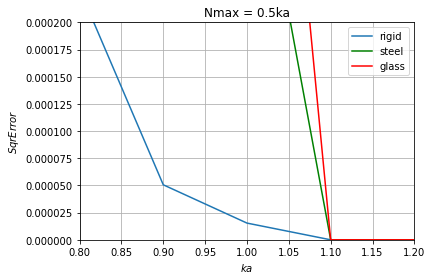

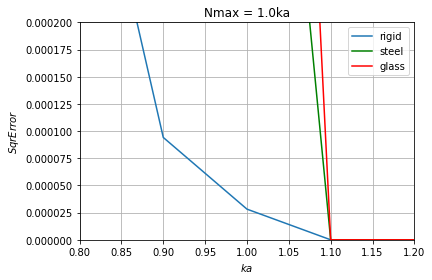

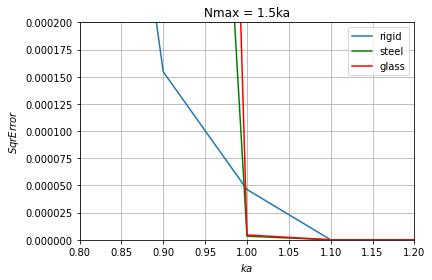

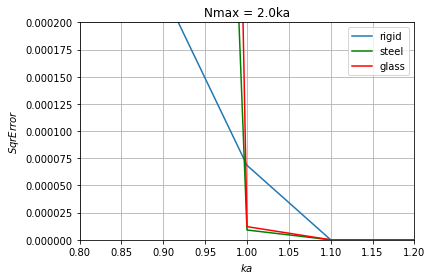

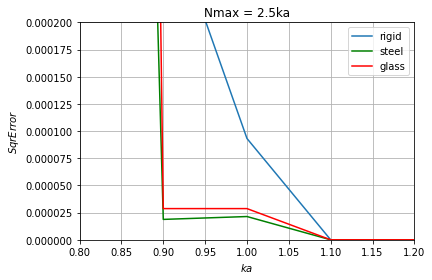

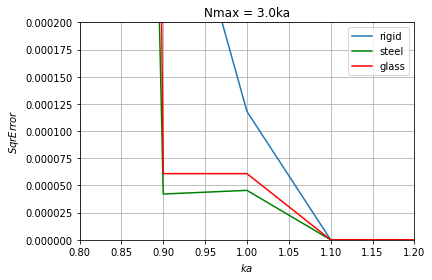

In [51]:
for ind in range(len(upper_lim_array)):
    plt.ylabel('$Sqr Error$')  
    plt.xlabel('$ka$')

    plt.plot(ka_array, error_rigid[ind], label='rigid')
    plt.plot(ka_array, error_steel[ind], label='steel',  color='green')
    plt.plot(ka_array, error_glass[ind], label='glass', color='red')
    grid1 = plt.grid(True)
    plt.xlim((0.8,1.2))
    plt.ylim((0, 0.0002))
    plt.legend()
    plt.title(f'Nmax = {upper_lim_array[ind]}ka')
    plt.show()